In [1]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [66]:
def get_preds(model, tokenizer, dset, text_to_append='', temp_scaling=None):
    text = tokenizer([f'{text_to_append} {x}' for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False)
    predictions = np.array([])
    actual = np.array([])
    probs = np.array([])
    for image, labels in tqdm(dataloader, total=len(dset) // batch_size):
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
            if temp_scaling is not None:
                image_features = torch.div(image_features, temp_scaling)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        vals, indics = text_probs.max(dim=1)
        predictions = np.append(predictions, indics.cpu().numpy())
        actual = np.append(actual, labels.numpy())
        probs = np.append(probs, vals.cpu().numpy())
    return predictions, actual, probs

In [4]:
def calc_bins(y_true, preds, confs, num_bins=10):
  # Assign each prediction to a bin
  bins = np.linspace(1.0 / num_bins, 1, num_bins)
  binned = np.digitize(confs, bins)

  # Save the accuracy, confidence and size of each bin
  bin_accs = np.zeros(num_bins)
  bin_confs = np.zeros(num_bins)
  bin_sizes = np.zeros(num_bins)

  for bin in range(num_bins):
    bin_sizes[bin] = len(preds[binned == bin])
    if bin_sizes[bin] > 0:
      bin_accs[bin] = np.mean(y_true[binned==bin] == preds[binned == bin])
      bin_confs[bin] = np.mean(confs[binned==bin])

  return bins, binned, bin_accs, bin_confs, bin_sizes

In [5]:
def get_metrics(y_true, preds, confs):
  ECE = 0
  MCE = 0
  bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)

  for i in range(len(bins)):
    abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
    ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
    MCE = max(MCE, abs_conf_dif)

  return ECE, MCE

In [6]:
def draw_reliability_graph(y_true, preds, confs, title=None):
  overall_acc = np.mean(y_true == preds)
  ECE, MCE = get_metrics(y_true, preds, confs)
  bins, _, bin_accs, _, _ = calc_bins(y_true, preds, confs)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.gca()

  # x/y limits
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0, 1)

  # x/y labels
  plt.xlabel('Confidence')
  plt.ylabel('Accuracy')

  # Create grid
  ax.set_axisbelow(True) 
  ax.grid(color='gray', linestyle='dashed')

  # Error bars
  plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
  plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
  plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
  plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
  ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
  MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
  acc_patch = mpatches.Patch(color='orange', label='Overall Accuracy = {:.2f}%'.format(overall_acc*100))
  plt.legend(handles=[ECE_patch, MCE_patch, acc_patch])
  if title is not None:
    plt.title(title)

Files already downloaded and verified


157it [00:20,  7.65it/s]                         


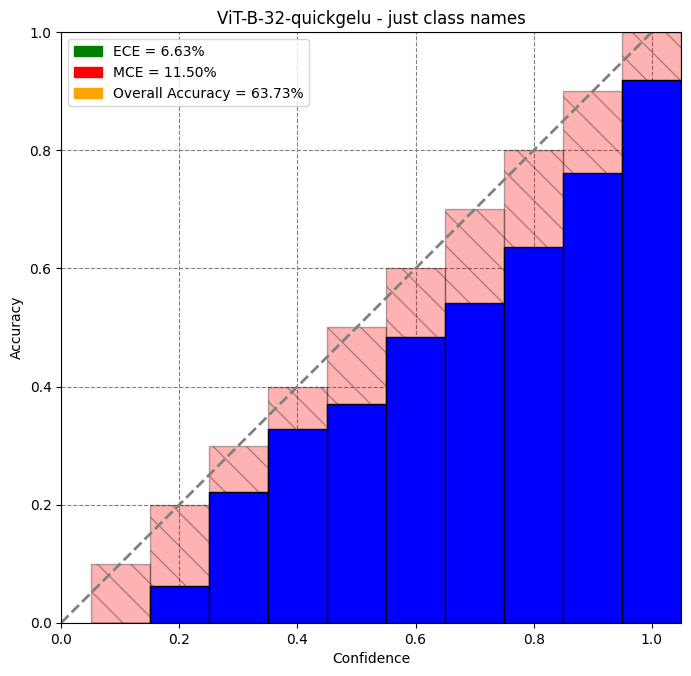

In [15]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append='')
draw_reliability_graph(actual, predictions, probs, f"{model_name} - just class names")

In [8]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

In [9]:
def get_val_set(val_transform):
    cifar_train = datasets.CIFAR100('/home/ubuntu/data/', train = True, transform = val_transform, download=True)
    np.random.seed(0)
    cifar_val = (torch.utils.data.Subset(cifar_train, np.random.randint(0, len(cifar_train), 10000)))
    cifar_val.classes = cifar_train.classes
    return cifar_val
cifar_val = get_val_set(preprocess)

Files already downloaded and verified


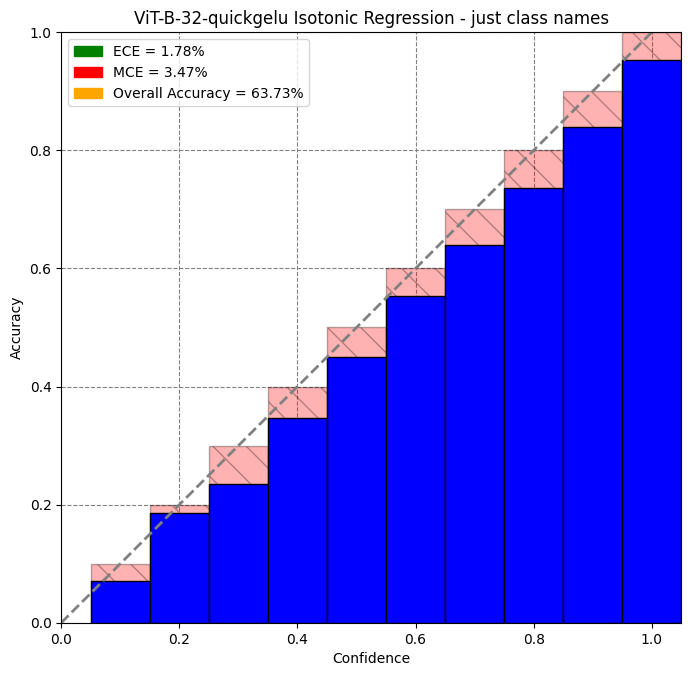

In [10]:
def run_isotonic(y_true, preds, confs):
    ir = IR( out_of_bounds = 'clip' )
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    ir.fit( bin_confs, bin_accs )
    p_calibrated = ir.transform( confs )
    return p_calibrated
calib = run_isotonic(actual, predictions, probs)
draw_reliability_graph(actual, predictions, calib , f"{model_name} Isotonic Regression - just class names")

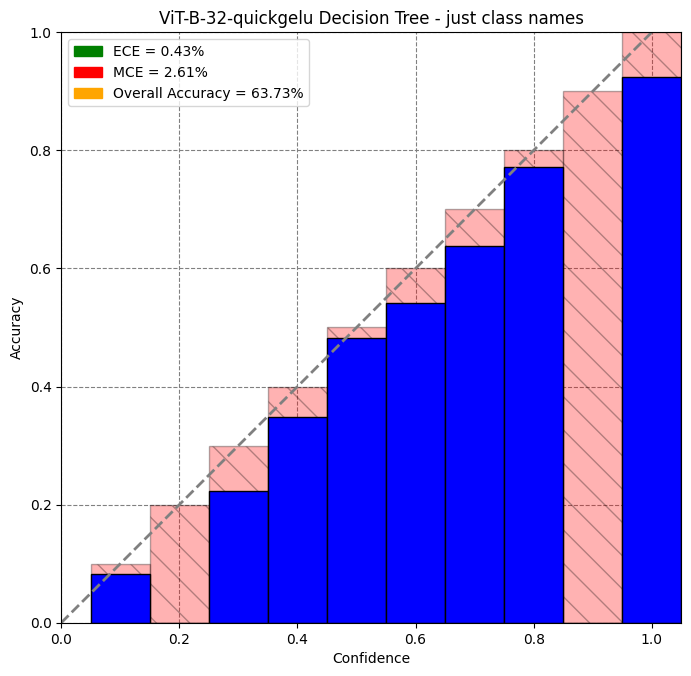

In [11]:
def run_decisiontree(y_true, preds, confs):
    dt = DT()
    bins, binned, bin_accs, bin_confs, bin_sizes = calc_bins(y_true, preds, confs)
    dt.fit( np.expand_dims(bin_confs,1), np.expand_dims(bin_accs,1) )
    p_calibrated = dt.predict( np.expand_dims(confs,1) )
    return p_calibrated
calib = run_decisiontree(actual, predictions, probs)
draw_reliability_graph(actual, predictions, calib , f"{model_name} Decision Tree - just class names")

In [23]:
def find_temp_scale(model, val_dset, z_score=1.0, show_loss=False, text_to_append='', logits_list=None, labels_list = None):
  temperature = nn.Parameter((torch.ones(1)).to(device))
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')
  if logits_list is None:
    logits_list = []
    labels_list = []
    temps = []
    losses = []

    text = tokenizer([f'{text_to_append} {x}' for x in val_dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    #all_thresh = []
    #all_quants = []
    val_loader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)
    for i, data in enumerate(tqdm(val_loader, 0)):
        #images, labels = data[0].to(device), data[1].to(device)
        images = data[0].to(device)

        model.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():
          image_features = model.encode_image(images)
          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_probs = (100.0 * image_features @ text_features.T)#.softmax(dim=-1) 
          thresh = torch.mean(text_probs, axis=1) + z_score * torch.std(text_probs, axis=1)
          #quantiles = torch.quantile(text_probs.float(), 0.92, dim=1)
          #all_quants.append(quantiles)
          #all_thresh.append(thresh)
          #thresh = quantiles
          for k in range(len(text_probs)):
            ct = 0
            for j in range(len(text_probs[0])):
              if text_probs[k][j] >= thresh[k]:
                logits_list.append(text_probs[k].unsqueeze(0))
                ct += 1
                #labels_list.append(text_probs.argmax(axis=1)) # text probs: 64,100
                labels_list.append(j)
            #print(ct)
    # Create tensors
    logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
    labels_list = torch.FloatTensor(labels_list).to(device).long()#torch.cat(labels_list).to(device)

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)

  #print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

  if show_loss:
    plt.subplot(121)
    plt.plot(list(range(len(temps))), temps)

    plt.subplot(122)
    plt.plot(list(range(len(losses))), [x.item() for x in losses])
    plt.show()
  return temperature.item(), logits_list, labels_list#, all_quants, all_thresh

100%|██████████| 157/157 [01:05<00:00,  2.40it/s]


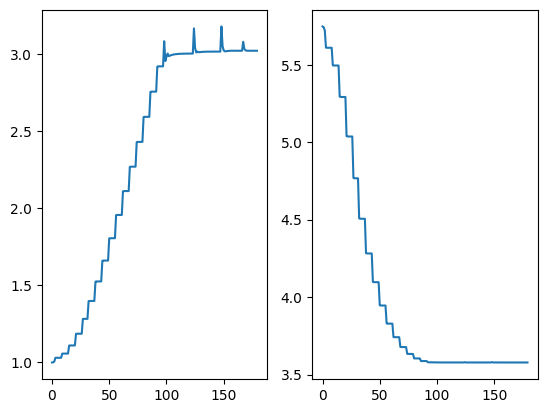

3.022312641143799

In [24]:
scaled_temp,_,_= find_temp_scale(model,  cifar_val, z_score=1.0, show_loss=True)
scaled_temp

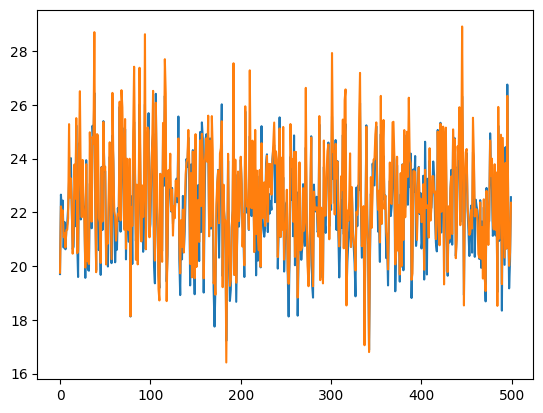

In [131]:
plt.plot(torch.cat(all_thresh).cpu().numpy()[:500])
plt.plot(torch.cat(all_quants).cpu().numpy()[:500])

157it [00:22,  7.04it/s]                         


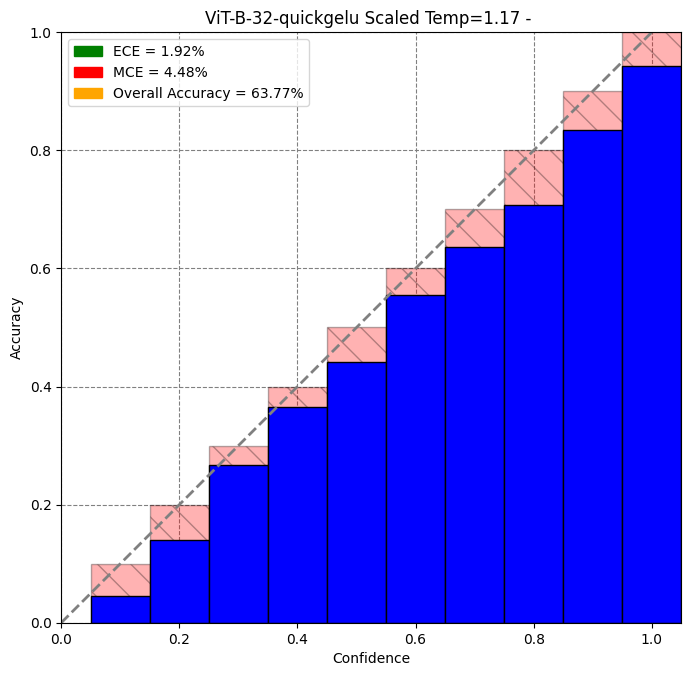

In [46]:
text_to_append = ''
scaled_temp = 1.1665139198303223
predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

In [28]:
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False)
all_val_img_features = None
for i, data in enumerate(tqdm(val_loader, 0)):
    #images, labels = data[0].to(device), data[1].to(device)
    images = data[0].to(device)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        if all_val_img_features is None:
            all_val_img_features = image_features
        else:
            all_val_img_features = torch.concat([all_val_img_features, image_features])
all_val_img_features.shape

100%|██████████| 157/157 [00:19<00:00,  8.10it/s]


torch.Size([10000, 512])

In [29]:
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
all_test_img_features = None
all_test_labels = None
for i, data in enumerate(tqdm(test_loader, 0)):
    #images, labels = data[0].to(device), data[1].to(device)
    images = data[0].to(device)

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        if all_test_img_features is None:
            all_test_img_features = image_features
            all_test_labels = data[1]
        else:
            all_test_img_features = torch.concat([all_test_img_features, image_features])
            all_test_labels = torch.concat([all_test_labels, data[1]])
all_test_img_features.shape

100%|██████████| 157/157 [00:18<00:00,  8.71it/s]


torch.Size([10000, 512])

In [30]:
assert cifar_test.classes == cifar_val.classes
text = tokenizer(cifar_test.classes)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text.to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)
text_features.shape

torch.Size([100, 512])

In [31]:
text_probs = (100.0 * all_test_img_features @ text_features.T)

In [32]:
def find_temp_scal_range(q):
  temperature = nn.Parameter((torch.ones(1)).to(device))
  args = {'temperature': temperature}
  criterion = nn.CrossEntropyLoss()

  logits_list = []
  labels_list = []
  temps = []
  losses = []
  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=70, line_search_fn='strong_wolfe')
  #thresholds = torch.quantile(text_probs.float(), q, axis=1)
  #thresholds = torch.mean(text_probs, axis=1) + q * torch.std(text_probs, axis=1)
  text_probs_numpy = text_probs.float().cpu().numpy()
  '''cdf = np.cumsum(text_probs_numpy, axis=1) / np.expand_dims(np.sum(text_probs_numpy, axis=1), 1)
  thresholds = np.zeros(len(cdf), dtype=float)
  for i, ind in enumerate(np.argmin(np.abs(cdf-q), axis=1)):
      thresholds[i] = text_probs_numpy[i][ind]'''

  thresholds = norm.ppf(q, loc=np.mean(text_probs_numpy, axis=1), scale = np.std(text_probs_numpy, axis=1))
  all_cts = []
  for k in range(len(text_probs)):
      cts = 0
      for j in range(len(text_probs[0])):
          if text_probs[k][j] >= thresholds[k]:
            cts += 1
            logits_list.append(text_probs[k].unsqueeze(0))
            labels_list.append(j)

      gr = text_probs[k] >= thresholds[k]
      all_cts.append(cts)
  #print(np.unique(all_cts, return_counts=True))
  #print(np.mean(np.array(cts)))
  logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
  labels_list = torch.FloatTensor(labels_list).to(device).long()

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)
  return temperature.item()

Text(0.5, 1.0, 'Quantile as a function of # Classes')

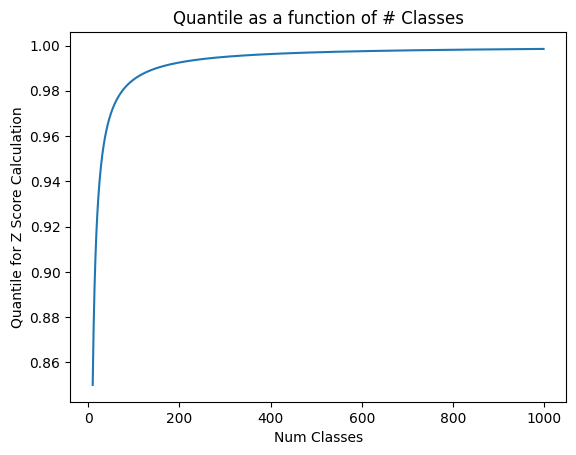

In [68]:
num_classes = np.arange(10,1000,1)
plt.plot(num_classes, 1 - (1 / num_classes) * 1.5)
plt.ylabel('Quantile for Z Score Calculation')
plt.xlabel('Num Classes')
plt.title('Quantile as a function of # Classes')

In [33]:
def get_preds_feats(temp_scaling):
    image_features = torch.div(all_test_img_features, temp_scaling)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    probs, predictions = text_probs.max(dim=1)
    return probs.cpu().numpy(), predictions.cpu().numpy()

In [38]:
temps = []
eces = []
x_axis = np.arange(0.95, 0.995, 0.005)
for q in tqdm(x_axis):
    scaled_temp = find_temp_scal_range(q)
    #predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append='', temp_scaling=scaled_temp)
    probs, predictions = get_preds_feats(scaled_temp)
    ECE, MCE = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
    temps.append(scaled_temp)
    eces.append(ECE * 100)

 80%|████████  | 4/5 [04:01<01:00, 60.26s/it]


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, UNKNOWN_TENSOR_TYPE_ID, Autocast, Batched, VmapMode].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:18433 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:26496 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:1068 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradMLC: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:10141 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:11560 [kernel]
UNKNOWN_TENSOR_TYPE_ID: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:466 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


Text(0.5, 1.0, 'CIFAR 100 - CDF ZScore')

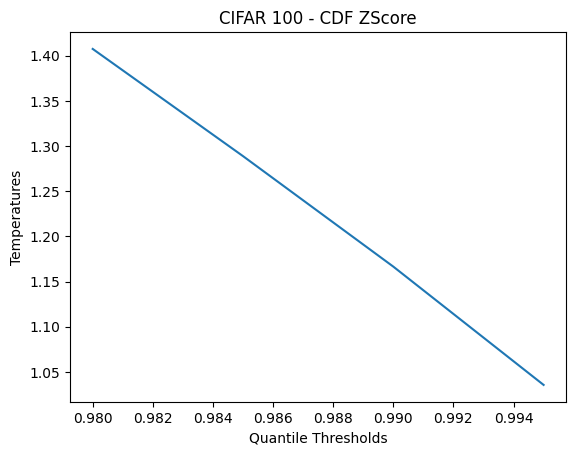

In [42]:
plt.plot(x_axis, temps)
plt.ylabel('Temperatures')
plt.xlabel('Quantile Thresholds')
plt.title('CIFAR 100 - CDF ZScore')

Text(0.5, 1.0, 'CIFAR 100 - CDF ZScore')

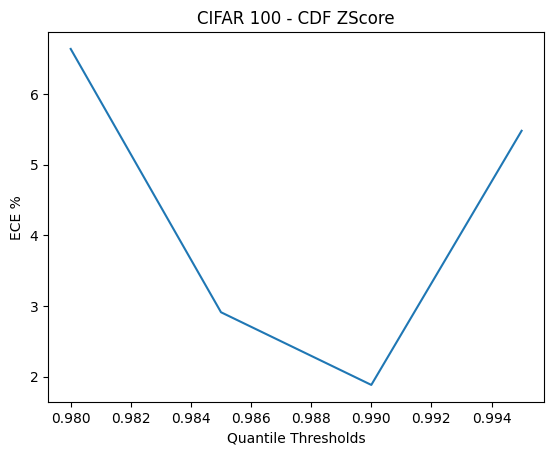

In [43]:
plt.plot(x_axis, eces)
plt.ylabel('ECE %')
plt.xlabel('Quantile Thresholds')
plt.title('CIFAR 100 - CDF ZScore')

In [44]:
min(eces)

1.8847082781758193

Text(0.5, 0, 'Z Scores')

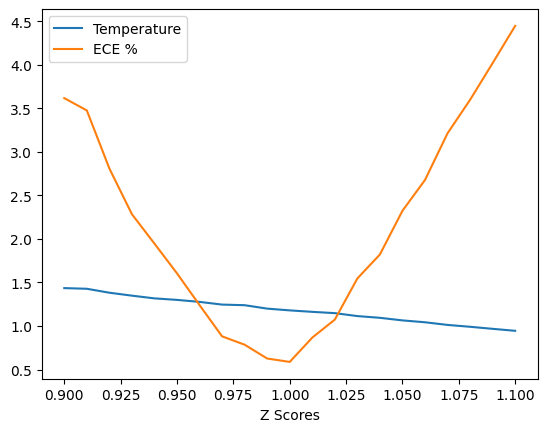

In [247]:
plt.plot(x_axis, temps, label='Temperature')
plt.plot(x_axis, eces, label='ECE %')
plt.legend()
plt.xlabel('Z Scores')

100%|██████████| 350/350 [00:00<00:00, 350.40it/s]


Text(0.5, 1.0, 'Temperature vs ECE - Zoomed in')

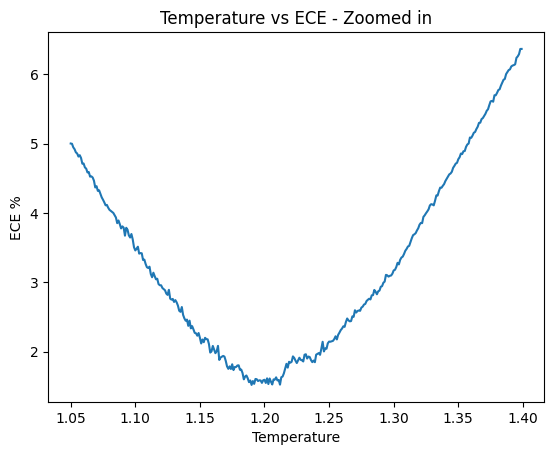

In [56]:
eces = []
temps = np.arange(1.05, 1.4, 0.001)
for scaled_temp in tqdm(temps):
    probs, predictions = get_preds_feats(scaled_temp)
    ECE, MCE = get_metrics(predictions, all_test_labels.cpu().numpy(), probs)
    eces.append(ECE * 100)
plt.plot(temps, eces)
plt.ylabel('ECE %')
plt.xlabel('Temperature')
plt.title('Temperature vs ECE - Zoomed in')

157it [00:20,  7.56it/s]                         
  0%|          | 0/156 [00:00<?, ?it/s]


TypeError: div(): argument 'other' (position 2) must be Tensor, not tuple

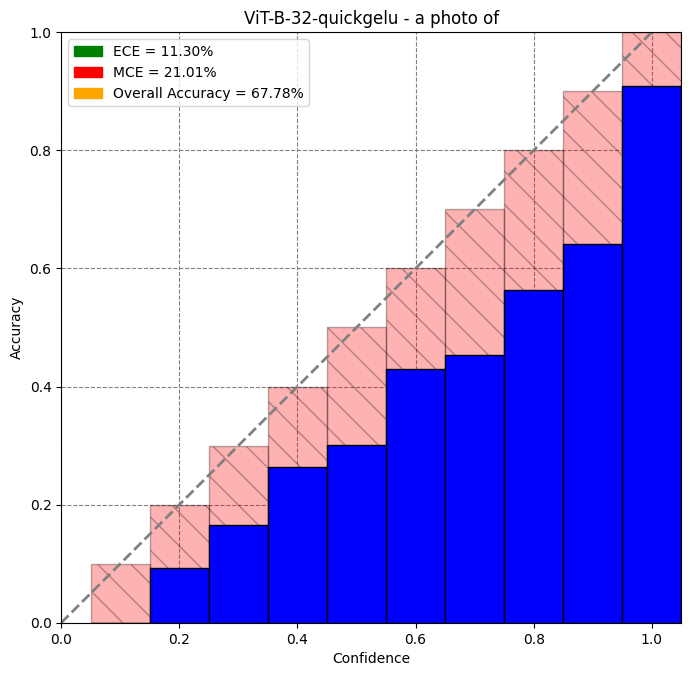

In [45]:
text_to_append = 'a photo of'
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

In [57]:
model_name = 'ViT-bigG-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion2b_s39b_b160k', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)


text_to_append = ''
predictions, actual, probs = get_preds(model, tokenizer, cifar_test, text_to_append=text_to_append)
draw_reliability_graph(actual, predictions, probs, f"{model_name} - {text_to_append}")
scaled_temp = find_temp_scale(model, cifar_val, show_loss=False)
cifar_val = get_val_set(preprocess)

predictions, actual, probs = get_preds(model, tokenizer, cifar_test,  text_to_append=text_to_append, temp_scaling=scaled_temp)
draw_reliability_graph(actual, predictions, probs, f"{model_name} Scaled Temp={scaled_temp:0.2f} - {text_to_append}")

Files already downloaded and verified


  0%|          | 0/156 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 260.00 MiB (GPU 6; 15.78 GiB total capacity; 13.01 GiB already allocated; 222.94 MiB free; 13.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [82]:
dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

image, _ = next(iter(dataloader))
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.to(device))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    #text_probs /= text_probs.sum()
    print(text_probs)
    text_probs = text_probs.norm(dim=-1,keepdim=True)
    print(text_probs)

In [83]:
text = tokenizer([f'{text_to_append} {x}' for x in cifar_test.classes])
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text.to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [84]:
text_probs.shape

torch.Size([64, 100])

In [86]:
text_probs.norm(dim=-1,keepdim=True).shape

torch.Size([64, 1])

In [87]:
text_probs.norm(dim=-1)

tensor([0.3838, 0.5539, 0.7975, 0.9972, 0.9056, 0.8831, 0.5631, 0.2855, 0.4139,
        0.8719, 0.9232, 0.3682, 0.9072, 0.7587, 0.7935, 0.9925, 0.9866, 0.3520,
        0.9955, 0.8001, 0.9398, 0.9847, 0.3950, 0.5821, 0.9928, 0.5219, 0.9997,
        0.9986, 0.9774, 0.9133, 0.8414, 0.9537, 0.8530, 0.5087, 0.5692, 0.9045,
        0.9997, 0.6829, 0.9788, 0.6877, 0.6399, 0.9272, 0.9734, 0.7224, 1.0000,
        0.5675, 0.8157, 0.9999, 0.2892, 0.4162, 0.7239, 0.9872, 0.9885, 0.9992,
        0.9268, 0.2890, 0.7825, 0.9885, 0.5818, 0.4231, 0.8469, 0.2591, 0.6254,
        0.5007], device='cuda:6')